# The 7 Assumptions of a Linear Model

In [1]:
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import random as rand
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import statsmodels.api as sm

## Ingestion of unscaled data

In [2]:
df_original = pd.read_csv("data/df_pre_training.csv")
df_optimization = df_original.copy()
df_optimization = df_optimization.drop("Unnamed: 0", axis=1)

# feature name correction
df_optimization.rename(columns={'MOBILE_NUMBER': 'MOBILE_NUMBER_SUPPLIED'}, inplace=True)

# preparing response variable data
predictor = 'HWT_SUBSCRIBER'
target = df_optimization.loc[:, predictor]
all_features = df_optimization.loc[:, df_optimization.columns.isin([predictor]) == False]

# Coeffecient Significance

## Class Definitions

In [3]:
class ModelResults():
    
    # Class to append results of modeling scenarios into a convenient wrapper
    #    - Assumes pandas as a preloaded resource
    def __init__(self, columns):
        self.columns = columns
        self.df = pd.DataFrame(columns = self.columns)
    
    # save results into class
    def save(self, model_dict_outcome):
        self.df = pd.concat([self.df, pd.DataFrame(model_dict_outcome)])
    
    # display results
    def display(self):
        return self.df
    
    # export results
    def export_csv(self, location):
        self.location = location
        self.df.to_csv(self.location)
    

## Function Definitions

In [5]:
def skl_train_test_pred_results(model, fit_X, fit_y, test_X, test_y, pred_X):
#     quick method to output model, train and test scores
    
    # Fit and score
    mod_fit = model.fit(fit_X, fit_y)
    mod_train_score = model.score(fit_X, fit_y)
    mod_test_score = model.score(test_X, test_y)
    y_pred = mod_fit.predict(pred_X)
    
    return mod_fit, mod_train_score, mod_test_score, y_pred

def skl_mod_confusion_matrix_roc_auc(y_true, y_pred, y_score):
    # Thus in binary classification, 
#         - C00, True  Negatives 
#         - C01, False Positive
#         - C10, False Negative  
#         - C11  True  Positive

    cm = confusion_matrix(y_true, y_pred)
    cm_score = {
        'TN': cm[0, 0],
        'FP': cm[0, 1],
        'FN': cm[1, 0],
        'TP': cm[1, 1]
    }
    
    return cm_score, roc_auc_score(y_true, y_score)

def statsmodel_ols_lgst(model_type, X_train, X_test, y_train, y_test):
    # Method to automate process of retrieving performance parameters
    
    model_spec = {
        'ols': sm.OLS(y_train, X_train).fit(),
        'lgst': sm.Logit(y_train, X_train).fit(method='ncg')
    }
    
    # Instantial model based on type requirement
    model = model_spec[model_type]
    
    # apply class heuristic
    #     - Any class less than 0.5: 0
    #     - ANy class greater than 0.5: 1
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    y_pred[y_pred < 0.5] = 0
    y_pred[y_pred >= 0.5] = 1
    y_pred = y_pred.astype(int)

    # Get scores: output interpreted as probability of predicting class 1
    mod_cm_score, mod_auc_score = skl_mod_confusion_matrix_roc_auc(y_test, y_pred, y_pred)
    mod_precision = mod_cm_score['TP']/(mod_cm_score['TP']+mod_cm_score['FP'])

    # Get significant features
    mod_sig_features = list(model.pvalues[model.pvalues <= 0.05].index.values)
    
    return model, mod_cm_score, mod_auc_score, mod_precision, mod_sig_features

## Field Definitions

In [6]:
# explicitely define outlier and threshold features
thresholds_eng = pd.DataFrame(columns=[
    'flag_SECONDS_WATCHING_PREP_VID_AVG_hi',
    'flag_SECONDS_WATCHING_PREP_VID_AVG_lo',
    'flag_SITE_VISIT_TIME_PER_VISIT_AVG_hi',
    'flag_SITE_VISIT_TIME_PER_VISIT_AVG_lo',
    'flag_PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE_hi',
    'flag_PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE_lo',
    'flag_TOTAL_MEALS_ORDERED_lo',
    'flag_UNIQUE_MEALS_PURCH_lo',
    'flag_CUSTOMER_SERVICE_TICKETS_CNT_lo',
    'flag_CUSTOMER_SERVICE_TICKETS_CNT_hi',
    'flag_PRODUCT_CATEGORIES_VIEWED_lo',
    'flag_PRODUCT_CATEGORIES_VIEWED_hi',
    'flag_ORDERS_DELIVERED_BEFORE_DELIVERY_CNT_lo',
    'flag_ORDERS_DELIVERED_BEFORE_DELIVERY_CNT_hi',
    'flag_ORDERS_DELIVERED_AFTER_DELIVERY_CNT_lo',
    'flag_ORDERS_DELIVERED_AFTER_DELIVERY_CNT_hi',
    'flag_MASTER_CLASSES_ATTENDED_CNT_hi',
    'flag_PHOTOS_VIEWED_COUNT_lo',
    'flag_WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT_lo'
])

outliers_eng = pd.DataFrame(columns=[
    'out_SITE_VISIT_TIME_PER_VISIT_AVG_hi',
    'out_SECONDS_WATCHING_PREP_VID_AVG_lo',
    'out_PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE_hi',
    'out_TOTAL_MEALS_ORDERED_hi',
    'out_UNIQUE_MEALS_PURCH_hi',
    'out_MEALS_CANCEL_BEFORE_NOON_hi',
    'out_MEALS_CANCEL_AFTER_NOON_hi',
    'out_PC_LOGINS_CNT_hi',
    'out_PC_LOGINS_CNT_lo',
    'out_MOBILE_LOGINS_CNT_lo',
    'out_MOBILE_LOGINS_CNT_hi',
])

# explicitely define engineered features
features_eng = pd.DataFrame(columns=[
    'fe_MEAL_CHOICE_SPECIFICITY', 'fe_SITE_CLICK_RATE', 'fe_SUBSCRIPTIONS_SYNERGY',
    'fe_CUSTOMER_COMPANY', 'fe_CUSTOMER_DOMAIN',
                    ])

continuous_features = pd.DataFrame(columns=[
    'REVENUE', 'SITE_VISIT_TIME_PER_VISIT_AVG', 'PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE', 
    'SECONDS_WATCHING_PREP_VID_AVG'
                    ])

# MOBILE_LOGINS_CNT dropped, collinearity
count_features = pd.DataFrame(columns=[
    'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CUSTOMER_SERVICE_TICKETS_CNT',
    'PRODUCT_CATEGORIES_VIEWED', 'MEALS_CANCEL_BEFORE_NOON', 'MEALS_CANCEL_AFTER_NOON',
    "PC_LOGINS_CNT", "WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT",
    "ORDERS_DELIVERED_BEFORE_DELIVERY_CNT", "ORDERS_DELIVERED_AFTER_DELIVERY_CNT",
    "MASTER_CLASSES_ATTENDED_CNT", 'SITE_CLICKS_PER_VISIT_AVG', 'PHOTOS_VIEWED_COUNT'
                    ])

string_features = pd.DataFrame(columns=[
    'NAME', 'EMAIL', 'FIRST_NAME','FAMILY_NAME'
                    ])

boolean_features = pd.DataFrame(columns=[
    'CROSS_SELL_SUCCESS', 'SPECIFIED_TASTE_AND_PREFERENCES',
    'PACKAGE_ROOM_AT_CUSTOMER', 'FRIDGE_LOCKER_IN_PACKAGE_ROOM', 
                   ])

discrete_features = pd.DataFrame(columns=[
    'MOBILE_NUMBER_SUPPLIED', 'LARGEST_ORDER_SIZE', 'MEAL_RATING_MEDIAN'
                    ])

professional_domain = [
    'mmm',
    'amex',
    'apple',
    'boeing',
    'caterpillar',
    'chevron',
    'cisco',
    'cocacola',
    'disney',
    'dupont',
    'exxon',
    'ge',
    'goldmansacs',
    'homedepot',
    'ibm',
    'intel',
    'jnj',
    'jpmorgan',
    'mcdonalds',
    'merck',
    'microsoft',
    'nike',
    'pfizer',
    'pg',
    'travelers',
    'unitedtech',
    'unitedhealth',
    'verizon',
    'visa',
    'walmart'
]

personal_domain = [
    'gmail',
    'yahoo',
    'protonmail',
]

junk_domain = [
    'me',
    'aol',
    'hotmail',
    'live',
    'msn',
    'passport',
]

# This classification was later found to produce a bug. Quick fix done to change get_unknown_domain key
unknown_domain = [
    float('nan')
]

company_domain_type = { 
    'com': 'for_profit',
    'org': 'non-profit'
}

get_professional_domain = dict(zip(professional_domain, ["professional_domain" for i in range(len(professional_domain))]))
get_personal_domain = dict(zip(personal_domain, ["personal_domain" for i in range(len(personal_domain))]))
get_junk_domain = dict(zip(junk_domain, ["junk_domain" for i in range(len(junk_domain))]))
get_unknown_domain = dict(zip(unknown_domain, ["for_proft_domain" for i in range(len(unknown_domain))]))

# explicitely define engineered features
features_eng = pd.DataFrame(columns=[
    'fe_MEAL_CHOICE_SPECIFICITY', 'fe_SITE_CLICK_RATE', 'fe_SUBSCRIPTIONS_SYNERGY',
    'fe_CUSTOMER_COMPANY', 'fe_CUSTOMER_DOMAIN',
                    ])

## Optimization strategy
- Remove redundant features
    - Test improvement
        - Criteria: count of p-values
- Scale all count, continuous and discrete
    - Test improvement
        - Criteria: count of p-values
- Transform all count, continuous and discrete
    - Test improvement
        - Criteria: count of p-values
- Scale count, discrete and transform continuous
    - Test improvement
        - Criteria: count of p-values
    

In [7]:
df_significant = df_optimization.copy()

# model comparison statistics
model_type = []
count_sig_features = []
sig_features = []
auc_score = []
sensitivity = []
notes = []

# feature set definition dictionary
sig_feature_sets = {}

# setup ModelResults class
modeling_optimal_results = ModelResults(["Model", "Transformation Method", "AUC", "AIC", "R2", "Precision", "Sig. features", "Notes"])

## Test on LR for Significance

In [8]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            df_significant.loc[:, df_significant.columns.isin([predictor]) == False],
            df_significant.loc[:, predictor],
            test_size = 0.25,
            random_state = 222)

In [9]:
lr_model_optimal, lr_optimal_cm_score, lr_optimal_auc_score, lr_mod_optimal_precision, sig_features = statsmodel_ols_lgst('ols', X_train, X_test, y_train, y_test)

# save results
modeling_optimal_results.save({
    "Model": ["LinReg"],
    "Transformation Method": ["Transform continuous, scale count and discrete"],
    "AUC": [lr_optimal_auc_score],
    "AIC": [lr_model_optimal.aic],
    "R2": [lr_model_optimal.rsquared],
    "Precision": [lr_mod_optimal_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Faled to converged on features"]
})


sig_feature_sets['pval_optimal_scale_train_lr'] = sig_features

Optimization terminated successfully.
         Current function value: 0.638760
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


## Test on Logit for Significance

In [10]:
lgst_model_optimal, lgst_optimal_cm_score, lgst_optimal_auc_score, lgst_mod_optimal_precision, sig_features = statsmodel_ols_lgst('lgst', X_train, X_test, y_train, y_test)

# save results
modeling_optimal_results.save({
    "Model": ["Logit"],
    "Transformation Method": ["Transform continuous, scale count and discrete"],
    "AUC": [lgst_optimal_auc_score],
    "AIC": [lgst_model_optimal.aic],
    "R2": [lgst_model_optimal.prsquared],
    "Precision": [lgst_mod_optimal_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Faled to converged on features"]
})

sig_feature_sets['pval_optimal_scale_train_lgst'] = sig_features

Optimization terminated successfully.
         Current function value: 0.638760
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [11]:
# Save results
file = "A2 - P-Value Optimization Performance Report.csv"
modeling_optimal_results.export_csv(file)

# Observe all performance
modeling_optimal_results.display()

Model                           Transformation Method       AUC  \
0  LinReg  Transform continuous, scale count and discrete  0.777794   
0   Logit  Transform continuous, scale count and discrete  0.500000   

           AIC        R2  Precision Sig. features  \
0  1254.877614  0.441937   0.861199            12   
0  2055.900677 -0.019708   0.673511             0   

                            Notes  
0  Faled to converged on features  
0  Faled to converged on features

Findings,
1. The linear regression was the most accurate a better AUC and Precision
2. The Logit regression lost the least amount of information during the transformations

Therefore, combine sets of features to capture both advantages for further optimization by non-parametric optimization

In [12]:
# Get optimal features before non-parametric optimization
optimal_features_lr_lgst = sig_feature_sets['pval_optimal_scale_train_lr'] + sig_feature_sets['pval_optimal_scale_train_lgst']

# Remove duplicates
nonparam_features = []
for i in optimal_features_lr_lgst:
    if i not in nonparam_features:
        nonparam_features.append(i)

In [36]:
class NormalityTest():
     
    # Determine whether the supplied function could be sampled from a Gaussian distribution
    #   - Normality tests have been validated by 100 randomly distributed normal floats
    #   - pandas is a pre-assumed dependency
    #      - NormalityTest(np.random.randn(100), 0.05, 0).get_result()
    #   - Source: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    
    from scipy import stats
    from numpy.random import seed, randn, seed
 
    def __init__(self, arr, alpha, dataframe, predictor_str):
        self.arr = arr
        self.alpha = alpha
        self.dataframe = dataframe
        self.predictor_str = predictor_str
        return None
    
    def check_normal_dist(self):
        return {
            'is_normally_distributed': {
                'shapiroWilk': self.shapiroWilk(self.alpha),
                'd_agostinoK2': self.d_agostinoK2(self.alpha),
                'anderson_darling': self.anderson_darling(self.alpha)},
        }
        
    def shapiroWilk(self, alpha):
        stat, p = self.stats.shapiro(self.arr)
        if p > alpha:
            return 'Gaussian (fail to reject H0)'
        else:
            return 'Not Gaussian (reject H0)'
    
    def d_agostinoK2(self, alpha):
        stat, p = self.stats.normaltest(self.arr)
        if p > alpha:
            return 'Gaussian (fail to reject H0)'
        else:
            return 'Not Gaussian (reject H0)'
        
    def anderson_darling(self, alpha):
        
        outcome = {
            "statistic": None,
            "percentile": [],
            "sl_cv": [],
            "result": []
        }
        # normality test
        result = self.stats.anderson(self.arr)
        statistic = result.statistic
        p = 0

        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                outcome['sl_cv'].append([sl, cv])
                outcome['result'].append(["Normal (Fail to reject H0)"])
            else:
                outcome['sl_cv'].append([sl, cv])
                outcome['result'].append(["Not Normal (Reject H0)"])
                
        outcome['statistic'] = statistic
        return outcome
    
    def check_population_mean(self, pop_mean):
        
        # NH: population mean is zero
        
        outcome = {}
        data = self.arr
        tset, pval = self.stats.ttest_1samp(data, pop_mean) # t-test
        if pval < 0.05:    # alpha value is 0.05 or 5%
            outcome['status'] = "Reject Null hypothesis"
        else:
            outcome['status'] = "Accept Null hypothesis"
        outcome['sample_mean'] = np.mean(data)
        return outcome
    
    def get_correlation_matrix(self):
        
        # arr and dataframe will be joined to produce correlation matrix
        return self.dataframe.join(pd.DataFrame({'arr': self.arr})).corr()
    
    
    def check_homoscedasticity(self, model):
        
        # generate a qqplot to visually inspect quantiles that break normality
        
        # We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity.
        #    - A p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.
        #    - Source: https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
 
        import pylab 
        import scipy.stats as stats

        measurements = model.resid  
        stats.probplot(measurements, dist="norm", plot=pylab)
        pylab.show()
    
    
    def get_vif(self):
        # Variance inflation factor to measure collinearity among features

        feature_name = []
        vif_value = []
        rsq_value = []
        self.df_vif = self.dataframe.copy()
        if self.predictor_str in self.df_vif.columns:
            self.df_vif = self.df_vif.drop([self.predictor_str], axis=1)
        
        for i in range(0, len(self.df_vif.columns)):
            # prepare features
            X = self.df_vif.loc[:, self.df_vif.columns != self.df_vif.columns[i]]
            y = self.df_vif.loc[:, self.df_vif.columns == self.df_vif.columns[i]]

            # Regress feature on every other feature
            lr = LinearRegression().fit(X, y)

            # Determine rsq
            rsq = lr.score(X, y)
            if rsq != 1:
                vif = round(1 / (1 - rsq), 2)
            else:
                vif = float("inf")

            feature_name.append(self.df_vif.columns[i])
            rsq_value.append(rsq)
            vif_value.append(vif)

        return pd.DataFrame({
                "r_squared": rsq_value,
                "vif": vif_value },
            index = feature_name
        ).sort_values(by="vif")

        

***

# Testing the 7 assumptions of a linear model

***

In [26]:
lr_model_optimal

1. The correctly specified regression model is linear in the coeffecients and the error term

2. The error term has a population mean of zero

In [18]:
lr_assumptions = NormalityTest(lr_model_optimal.resid, 0.05, X_train, 'HWT_SUBSCRIBER')
print(lr_assumptions.check_population_mean(0))

{'status': 'Accept Null hypothesis', 'sample_mean': -1.0628920636027544e-15}


3. All independent variables are uncorrelated with error terms

In [19]:
lr_assumptions.get_correlation_matrix().loc[:, "arr"]

REVENUE                                   9.270364e-16
TOTAL_MEALS_ORDERED                       6.857786e-15
UNIQUE_MEALS_PURCH                       -8.886496e-15
CUSTOMER_SERVICE_TICKETS_CNT             -4.217363e-15
PRODUCT_CATEGORIES_VIEWED                 9.101792e-16
                                              ...     
fe_CUSTOMER_DOMAIN_for_proft_domain      -8.582454e-17
fe_CUSTOMER_DOMAIN_junk_domain           -2.419394e-15
fe_CUSTOMER_DOMAIN_personal_domain        7.625030e-16
fe_CUSTOMER_DOMAIN_professional_domain    1.235362e-15
arr                                       1.000000e+00
Name: arr, Length: 103, dtype: float64

4. Error terms are uncorrelated with each other
    - Assess this assumption by graphing residuals in order they were recieved
    - You want to see randomness in the plot
    - Or, the coeffecient of err term in a linear regression should be close to zero with confidence

Coeffecient: x1    0.000007
dtype: float64, p-value: 0.522


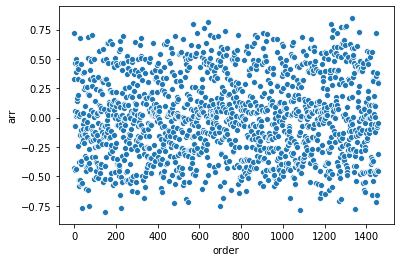

In [20]:
as_4 = sm.OLS(lr_model_optimal.resid, [i for i in range(0, len(lr_model_optimal.resid), 1)]).fit()
print("Coeffecient: {}, p-value: {}".format(as_4.params, round(as_4.pvalues[0], 4)))
sns.scatterplot(
    x = 'order',
    y = 'arr',
    data = pd.DataFrame({"arr": lr_model_optimal.resid, "order": [i for i in range(0, len(lr_model_optimal.resid), 1)]})
)

5. Error terms, as a distribution, has constant variance
    - Homoscedasticity of distribution
    - Symmetry between errors
    - Ok to use this
    - Tails fanning out - Normal
        - Not enough sample sizes on the tails to verify homosc.
        - Cooks distance -> See if tails are leveraging to the extent that they're affecting 
    - Studentized QQ plot
    - Good reason to remove quanitle residuals
        

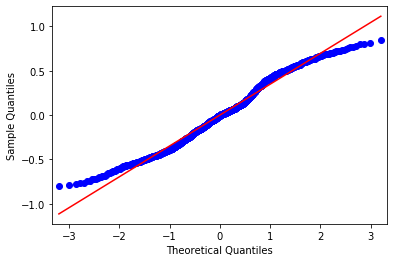

In [21]:
qqplot_homo = lr_assumptions.check_homoscedasticity()

6. No Independent variable is a perfect linear function of other explanatory varables
    - Variance Inflation Factor(VIF) for each feature

In [22]:
vif = lr_assumptions.get_vif()

# multicollinear features
vif[(vif.vif > 10) & (vif.vif < 50)]

r_squared    vif
CUSTOMER_SERVICE_TICKETS_CNT   0.900219  10.02
MOBILE_LOGINS_CNT              0.956478  22.98

7. The error term is normally distributed
    - OLS does not require the error term to be normally distributed to produce unbiased estimates
    - If normally distributed, can generate reliable confidence intervals and prediction intervals

In [24]:
lr_assumptions.check_normal_dist()["is_normally_distributed"]

{'shapiroWilk': 'Not Gaussian (reject H0)',
 'd_agostinoK2': 'Not Gaussian (reject H0)',
 'anderson_darling': {'statistic': 6.279591341243304,
  'percentile': [],
  'sl_cv': [[15.0, 0.574],
   [10.0, 0.654],
   [5.0, 0.785],
   [2.5, 0.916],
   [1.0, 1.089]],
  'result': [['Not Normal (Reject H0)'],
   ['Not Normal (Reject H0)'],
   ['Not Normal (Reject H0)'],
   ['Not Normal (Reject H0)'],
   ['Not Normal (Reject H0)']]}}

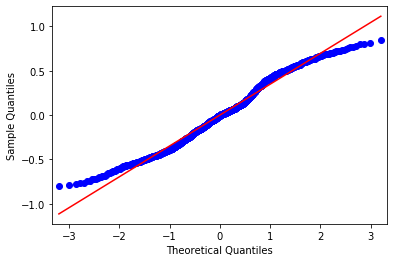

In [25]:
qqplot_homo = lr_assumptions.check_homoscedasticity()

In [35]:
pd.concat([X_train, y_train]).corr()

0  CUSTOMER_SERVICE_TICKETS_CNT  \
0                                     1.0                           NaN   
CUSTOMER_SERVICE_TICKETS_CNT          NaN                      1.000000   
FRIDGE_LOCKER_IN_PACKAGE_ROOM         NaN                      0.012764   
LARGEST_ORDER_SIZE                    NaN                     -0.006452   
MASTER_CLASSES_ATTENDED_CNT           NaN                     -0.002636   
...                                   ...                           ...   
out_SECONDS_WATCHING_PREP_VID_AVG_lo  NaN                      0.065102   
out_SITE_CLICKS_PER_VISIT_AVG_lo      NaN                     -0.012378   
out_SITE_VISIT_TIME_PER_VISIT_AVG_hi  NaN                      0.009358   
out_TOTAL_MEALS_ORDERED_hi            NaN                      0.062230   
out_UNIQUE_MEALS_PURCH_hi             NaN                      0.047053   

                                      FRIDGE_LOCKER_IN_PACKAGE_ROOM  \
0                                                               NaN   
CUSTOMER_SERVICE_TICKETS_CNT                               0.012764   
FRIDGE_LOCKER_IN_PACKAGE_ROOM                              1.000000   
LARGEST_ORDER_SIZE                                         0.013144   
MASTER_CLASSES_ATTENDED_CNT                                0.034830   
...                                                             ...   
out_SECONDS_WATCHING_PREP_VID_AVG_lo                      -0.013230   
out_SITE_CLICKS_PER_VISIT_AVG_lo                          -0.016209   
out_SITE_VISIT_TIME_PER_VISIT_AVG_hi                      -0.026515   
out_TOTAL_MEALS_ORDERED_hi                                 0.016092   
out_UNIQUE_MEALS_PURCH_hi                                  0.027148   

                                      LARGEST_ORDER_SIZE  \
0                                                    NaN   
CUSTOMER_SERVICE_TICKETS_CNT                   -0.006452   
FRIDGE_LOCKER_IN_PACKAGE_ROOM                   0.013144   
LARGEST_ORDER_SIZE                              1.000000   
MASTER_CLASSES_ATTENDED_CNT                     0.310344   
...                                                  ...   
out_SECONDS_WATCHING_PREP_VID_AVG_lo           -0.082389   
out_SITE_CLICKS_PER_VISIT_AVG_lo                0.045774   
out_SITE_VISIT_TIME_PER_VISIT_AVG_hi            0.116876   
out_TOTAL_MEALS_ORDERED_hi                      0.059135   
out_UNIQUE_MEALS_PURCH_hi                       0.073788   

                                      MASTER_CLASSES_ATTENDED_CNT  \
0                                                             NaN   
CUSTOMER_SERVICE_TICKETS_CNT                            -0.002636   
FRIDGE_LOCKER_IN_PACKAGE_ROOM                            0.034830   
LARGEST_ORDER_SIZE                                       0.310344   
MASTER_CLASSES_ATTENDED_CNT                              1.000000   
...                                                           ...   
out_SECONDS_WATCHING_PREP_VID_AVG_lo                    -0.034318   
out_SITE_CLICKS_PER_VISIT_AVG_lo                         0.028955   
out_SITE_VISIT_TIME_PER_VISIT_AVG_hi                     0.076400   
out_TOTAL_MEALS_ORDERED_hi                               0.055751   
out_UNIQUE_MEALS_PURCH_hi                                0.077639   

                                      MEALS_CANCEL_AFTER_NOON  \
0                                                         NaN   
CUSTOMER_SERVICE_TICKETS_CNT                        -0.032932   
FRIDGE_LOCKER_IN_PACKAGE_ROOM                       -0.026526   
LARGEST_ORDER_SIZE                                   0.003554   
MASTER_CLASSES_ATTENDED_CNT                         -0.005652   
...                                                       ...   
out_SECONDS_WATCHING_PREP_VID_AVG_lo                -0.014031   
out_SITE_CLICKS_PER_VISIT_AVG_lo                    -0.017191   
out_SITE_VISIT_TIME_PER_VISIT_AVG_hi                -0.028121   
out_TOTAL_MEALS_ORDERED_hi                          -0.022209   
out_UNIQUE_MEALS_PURC